Setup

In [ ]:
import os
import hashlib3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from rembg import remove
from PIL import Image
from io import BytesIO
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Dataset Loading
base_dir = r'C:\Users\ADMIN\OneDrive\Desktop\Master Folder'
train_dir = os.path.join(base_dir, 'train')

# Visualize dataset structure
for dirpath, dirnames, filenames in os.walk(train_dir):
    print(f"Found {len(filenames)} images in {dirpath}")

class_names = os.listdir(train_dir)

Found 0 images in C:\Users\ADMIN\OneDrive\Desktop\Term 10\Computer Vision\Assignments\Assignment 4\Master Folder\train
Found 250 images in C:\Users\ADMIN\OneDrive\Desktop\Term 10\Computer Vision\Assignments\Assignment 4\Master Folder\train\Angry
Found 250 images in C:\Users\ADMIN\OneDrive\Desktop\Term 10\Computer Vision\Assignments\Assignment 4\Master Folder\train\happy
Found 250 images in C:\Users\ADMIN\OneDrive\Desktop\Term 10\Computer Vision\Assignments\Assignment 4\Master Folder\train\Other
Found 250 images in C:\Users\ADMIN\OneDrive\Desktop\Term 10\Computer Vision\Assignments\Assignment 4\Master Folder\train\Sad


Processing

In [ ]:
import os
import numpy as np
import tensorflow as tf
from rembg import remove
from PIL import Image
from io import BytesIO
from tensorflow.keras.utils import img_to_array

images = []
labels = []

# Sorted assuming they are named by class
class_names = sorted(os.listdir(train_dir))

# Map class names to indices
class_to_idx = {class_name: index for index, class_name in enumerate(class_names)}

# Function to process images using TensorFlow
@tf.function
def process_image(image): # Convert image to float32 tensor, normalize, and resize
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224
    image = image / 255.0  # Normalize
    return image

# Iterate through all class folders and files
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    class_files = os.listdir(class_dir)

    for file in class_files:
        file_path = os.path.join(class_dir, file)
        try:
            # Read the image file and remove the background
            with open(file_path, "rb") as input_file:
                output_image_data = remove(input_file.read())

            # Save the processed image temporarily in memory
            output_image = Image.open(BytesIO(output_image_data))
            output_image_array = np.array(output_image)

            image_tensor = tf.convert_to_tensor(output_image_array, dtype=tf.float32)
            processed_image = process_image(image_tensor)

            # Append the processed image and label
            images.append(processed_image.numpy())  # Convert tensor to numpy array
            labels.append(class_to_idx[class_name])

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

# Convert lists to numpy arrays for further processing
images = np.array(images)
labels = np.array(labels)
print(f"Processed {len(images)} images and {len(labels)} labels.")

Processed 1000 images and 1000 labels.


Display

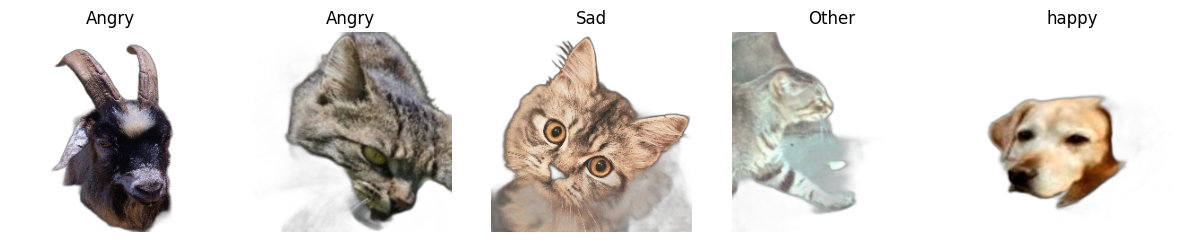

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def display_random_images(processed_images, labels, class_names, num_images=5):
    
    indices = random.sample(range(len(processed_images)), num_images)
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        image = processed_images[idx]
        label = labels[idx]
        
        # If the label is an array (e.g., one-hot encoded), take the index of the class
        if isinstance(label, np.ndarray):
            label = np.argmax(label)  # Get the index of the class
        
        # Ensure label is an integer index and access class_names
        class_name = class_names[label] if isinstance(label, int) else class_names[int(label)]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

# Example
display_random_images(images, labels, class_names, num_images=5)

In [ ]:
# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

labels = to_categorical(labels, num_classes=len(class_names))

# Split the dataset into 70% training, 15% validation, and 15% test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shape of data splits
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Create ImageDataGenerators for each subset
# Define data generators for the subsets
train_datagen = ImageDataGenerator(
    rotation_range=12,          
    horizontal_flip=True,    
    # zoom_range=0.2,           
    # rescale=1./255,     
    # width_shift_range=0.2,    # Randomly translate horizontally
    # height_shift_range=0.2,   # Randomly translate vertically
    # shear_range=0.2,          # Shear transformation
    # fill_mode='nearest'       # Fill missing pixels after transformations         
)

# Validation and test generators (no augmentation)
valid_test_datagen = ImageDataGenerator(
    # rescale=1./255
)
batch_size=8

# Convert the data into generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = valid_test_datagen.flow(X_valid, y_valid, batch_size=batch_size, shuffle=True)
test_generator = valid_test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

X_train shape: (700, 224, 224, 4), y_train shape: (700, 4)
X_valid shape: (150, 224, 224, 4), y_valid shape: (150, 4)
X_test shape: (150, 224, 224, 4), y_test shape: (150, 4)


# VGG
VGG16 has 13 convolutional layers with 3×3 filters, grouped into 5 blocks with max pooling. It ends with two large fully connected layers and a softmax output. Known for its simplicity and strong baseline accuracy.

In [12]:
def build_vgg_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.1),
        Dense(4096, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ResNet
ResNet50 is a 50-layer network with residual connections that help train deep models by avoiding vanishing gradients. It uses batch normalization and global average pooling before the final softmax layer.

In [ ]:
def build_resnet_model(input_shape, num_classes):
    def residual_block(x, filters):
        shortcut = x
        if x.shape[-1] != filters:
            shortcut = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', activation=None)(shortcut)

        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding='same', activation=None)(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.add([shortcut, x])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for _ in range(3):
        x = residual_block(x, 64)

    for _ in range(4):
        x = residual_block(x, 128)

    for _ in range(6):
        x = residual_block(x, 256)

    for _ in range(3):
        x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# MobileNet
MobileNet is a lightweight model for mobile devices, using depthwise separable convolutions to reduce computation. It efficiently captures features with fewer parameters and good accuracy.

In [14]:
def build_mobilenet_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),

        DepthwiseConv2D((3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (1, 1), activation='relu'),
        BatchNormalization(),

        DepthwiseConv2D((3, 3), strides=(2, 2), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (1, 1), activation='relu'),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Inception
InceptionV3 uses parallel convolutions of different sizes to capture features at multiple scales. It includes an auxiliary classifier and ends with global average pooling, balancing speed and accuracy.

In [ ]:
def build_inception_model(input_shape, num_classes): # Simplified inception module implementation
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    branch1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)

    branch2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    branch2 = Conv2D(128, (3, 3), padding='same', activation='relu')(branch2)

    branch3 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)

    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)

    x = tf.keras.layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    x = GlobalAveragePooling2D()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# DenseNet
DenseNet121 connects each layer to all previous ones, promoting feature reuse and efficient training. It uses fewer parameters and ends with global average pooling and softmax for classification.

In [ ]:
def build_densenet_model(input_shape, num_classes):
    def dense_block(x, growth_rate, layers):
        for _ in range(layers):
            bn = BatchNormalization()(x)
            relu = tf.keras.layers.Activation('relu')(bn)
            conv = Conv2D(growth_rate, (3, 3), padding='same')(relu)
            x = tf.keras.layers.concatenate([x, conv])
        return x

    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = dense_block(x, 32, 6)
    x = MaxPooling2D((2, 2))(x)
    x = dense_block(x, 32, 12)
    x = MaxPooling2D((2, 2))(x)
    x = dense_block(x, 32, 24)
    x = MaxPooling2D((2, 2))(x)
    x = dense_block(x, 32, 16)
    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

Training Models

In [ ]:
input_shape = (224, 224, 4)
num_classes = len(class_names)

models = {
    "VGG16": build_vgg_model(input_shape, num_classes),
    "ResNet50": build_resnet_model(input_shape, num_classes),
    "MobileNet": build_mobilenet_model(input_shape, num_classes),
    "InceptionV3": build_inception_model(input_shape, num_classes),
    "DenseNet121": build_densenet_model(input_shape, num_classes)
}

results = {}
for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=50,
    )

    # Evaluate model
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
    confusion = confusion_matrix(true_classes, predicted_classes)

    results[name] = {
        "accuracy": report["accuracy"],
        "classification_report": report,
        "confusion_matrix": confusion
    }

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model: VGG16
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1735593321.778491     106 service.cc:145] XLA service 0x7cfb900b0fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735593321.778553     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/88 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.1875 - loss: 7.7078  

I0000 00:00:1735593332.658064     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1735593332.667217     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/88 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.1968 - loss: 8.1716

I0000 00:00:1735593340.890713     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 356 bytes spill stores, 356 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.2570 - loss: 2.6818 - val_accuracy: 0.2200 - val_loss: 1.3877
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2554 - loss: 1.3862 - val_accuracy: 0.2200 - val_loss: 1.3872
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2179 - loss: 1.3867 - val_accuracy: 0.2200 - val_loss: 1.3868
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.2319 - loss: 1.3867 - val_accuracy: 0.2200 - val_loss: 1.3870
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.2573 - loss: 1.3866 - val_accuracy: 0.2200 - val_loss: 1.3869
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.2611 - loss: 1.3860 - val_accuracy: 0.2200 - val_loss: 1.3871
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.2731 - loss: 1.3860 - val_accuracy: 0.2200 - val_loss: 1.3866
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2451 - loss: 1.3864 - val_accuracy: 0.2200 - val_loss

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50


I0000 00:00:1735593842.536384     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_16', 36 bytes spill stores, 36 bytes spill loads



 5/88 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - accuracy: 0.1854 - loss: 3.9524  

I0000 00:00:1735593856.057528     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_16', 36 bytes spill stores, 36 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 455ms/step - accuracy: 0.2624 - loss: 2.8119 - val_accuracy: 0.2200 - val_loss: 590.6036
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.3160 - loss: 1.5032 - val_accuracy: 0.3200 - val_loss: 2.3622
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.3077 - loss: 1.4530 - val_accuracy: 0.2600 - val_loss: 2.7157
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.3177 - loss: 1.4051 - val_accuracy: 0.2533 - val_loss: 1.4446
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.2691 - loss: 1.4319 - val_accuracy: 0.2400 - val_loss: 1.5809
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.2863 - loss: 1.4663 - val_accuracy: 0.2800 - val_loss: 1.7859
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.2603 - loss: 1.4150 - val_accuracy: 0.2533 - val_loss: 1.7665
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.2940 - loss: 1.3736 - val_accuracy: 0.2

I0000 00:00:1735595001.388434     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 388 bytes spill stores, 388 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_maximum_reduce_fusion_1', 40 bytes spill stores, 40 bytes spill loads



74/88 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2887 - loss: 1.4231

I0000 00:00:1735595010.183017     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 388 bytes spill stores, 388 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_maximum_reduce_fusion_1', 40 bytes spill stores, 40 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 0.2931 - loss: 1.4183 - val_accuracy: 0.2600 - val_loss: 1.4587
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2927 - loss: 1.3673 - val_accuracy: 0.2600 - val_loss: 1.5494
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.3847 - loss: 1.3394 - val_accuracy: 0.2600 - val_loss: 1.5858
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.3094 - loss: 1.3641 - val_accuracy: 0.2533 - val_loss: 1.5000
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3326 - loss: 1.3478 - val_accuracy: 0.2400 - val_loss: 1.4666
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3682 - loss: 1.3193 - val_accuracy: 0.2200 - val_loss: 1.6048
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.3599 - loss: 1.3360 - val_accuracy: 0.3000 - val_loss: 1.6108
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.3831 - loss: 1.3273 - val_accuracy: 0.2800 - val_loss: 

I0000 00:00:1735595417.456598     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 36 bytes spill stores, 36 bytes spill loads



27/88 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.2304 - loss: 1.4150

I0000 00:00:1735595420.899518     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 36 bytes spill stores, 36 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.2421 - loss: 1.4009 - val_accuracy: 0.2267 - val_loss: 1.3768
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2802 - loss: 1.3783 - val_accuracy: 0.2867 - val_loss: 1.3763
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2959 - loss: 1.3686 - val_accuracy: 0.2867 - val_loss: 1.3649
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.2974 - loss: 1.3732 - val_accuracy: 0.3067 - val_loss: 1.3513
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3114 - loss: 1.3589 - val_accuracy: 0.2200 - val_loss: 1.4024
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.2947 - loss: 1.3759 - val_accuracy: 0.2800 - val_loss: 1.3808
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.3272 - loss: 1.3658 - val_accuracy: 0.3533 - val_loss: 1.3696
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.3311 - loss: 1.3489 - val_accuracy: 0.2867 - val_loss: 

I0000 00:00:1735595932.887672     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_275', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_273', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_30', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_31', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_6', 448 bytes spill stores, 436 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion', 584 bytes spill 

15/88 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.2107 - loss: 51.6257

I0000 00:00:1735596002.273343     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_261', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_259', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_25', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_26', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion', 612 bytes spill stores, 592 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion', 584 bytes 

88/88 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.2425 - loss: 26.6630 - val_accuracy: 0.2400 - val_loss: 2.5609
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.3271 - loss: 3.8454 - val_accuracy: 0.2200 - val_loss: 2.5010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.3010 - loss: 2.7407 - val_accuracy: 0.2600 - val_loss: 1.5971
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.2810 - loss: 2.2792 - val_accuracy: 0.3333 - val_loss: 1.4833
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.3402 - loss: 1.6153 - val_accuracy: 0.3000 - val_loss: 1.6909
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.2977 - loss: 1.6823 - val_accuracy: 0.2733 - val_loss: 1.5359
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.3334 - loss: 1.4861 - val_accuracy: 0.2600 - val_loss: 1.5335
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.3167 - loss: 1.5570 - val_accuracy: 0.3267 - val_l

Results Analysis


Results for VGG16:
Accuracy: 0.26
Classification Report:
              precision  recall  f1-score  support
Angry            0.2600    1.00  0.412698    39.00
Other            0.0000    0.00  0.000000    39.00
Sad              0.0000    0.00  0.000000    35.00
happy            0.0000    0.00  0.000000    37.00
accuracy         0.2600    0.26  0.260000     0.26
macro avg        0.0650    0.25  0.103175   150.00
weighted avg     0.0676    0.26  0.107302   150.00
Confusion Matrix:
[[39  0  0  0]
 [39  0  0  0]
 [35  0  0  0]
 [37  0  0  0]]


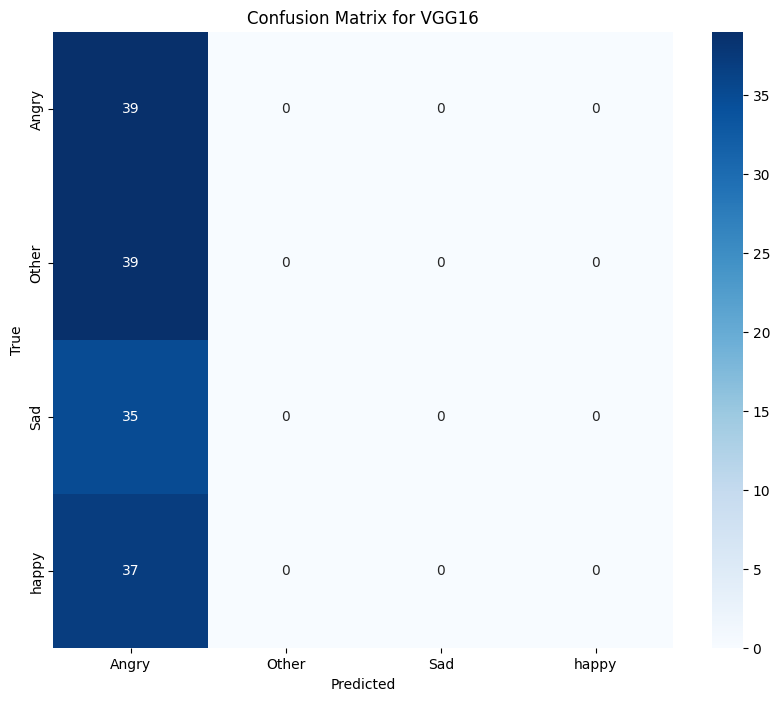


Results for ResNet50:
Accuracy: 0.3933333333333333
Classification Report:
              precision    recall  f1-score     support
Angry          0.371429  0.666667  0.477064   39.000000
Other          0.382979  0.461538  0.418605   39.000000
Sad            0.666667  0.057143  0.105263   35.000000
happy          0.433333  0.351351  0.388060   37.000000
accuracy       0.393333  0.393333  0.393333    0.393333
macro avg      0.463602  0.384175  0.347248  150.000000
weighted avg   0.458590  0.393333  0.353157  150.000000
Confusion Matrix:
[[26 10  1  2]
 [16 18  0  5]
 [14  9  2 10]
 [14 10  0 13]]


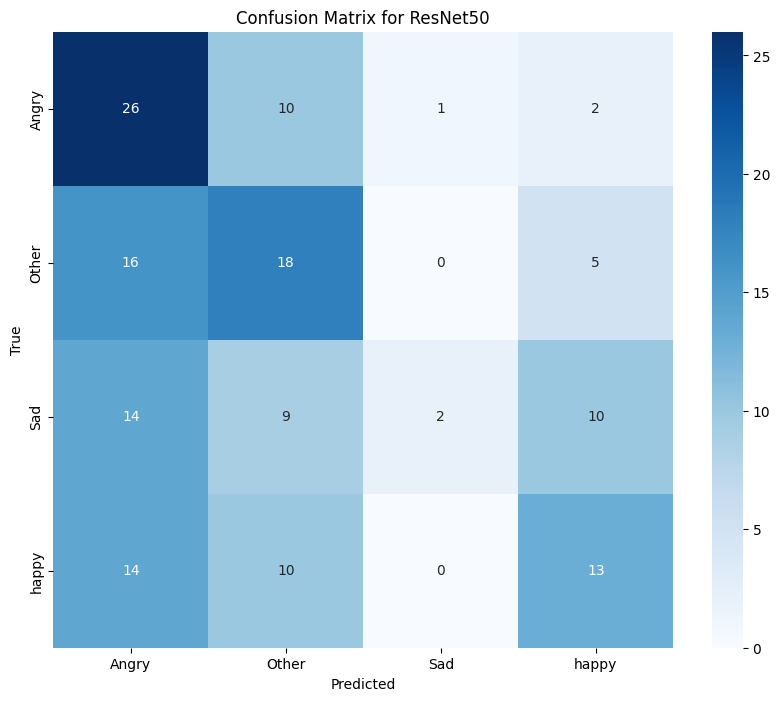


Results for MobileNet:
Accuracy: 0.36666666666666664
Classification Report:
              precision    recall  f1-score     support
Angry          0.418182  0.589744  0.489362   39.000000
Other          0.259259  0.179487  0.212121   39.000000
Sad            0.333333  0.342857  0.338028   35.000000
happy          0.406250  0.351351  0.376812   37.000000
accuracy       0.366667  0.366667  0.366667    0.366667
macro avg      0.354256  0.365860  0.354081  150.000000
weighted avg   0.354121  0.366667  0.354206  150.000000
Confusion Matrix:
[[23  5  5  6]
 [14  7 11  7]
 [11  6 12  6]
 [ 7  9  8 13]]


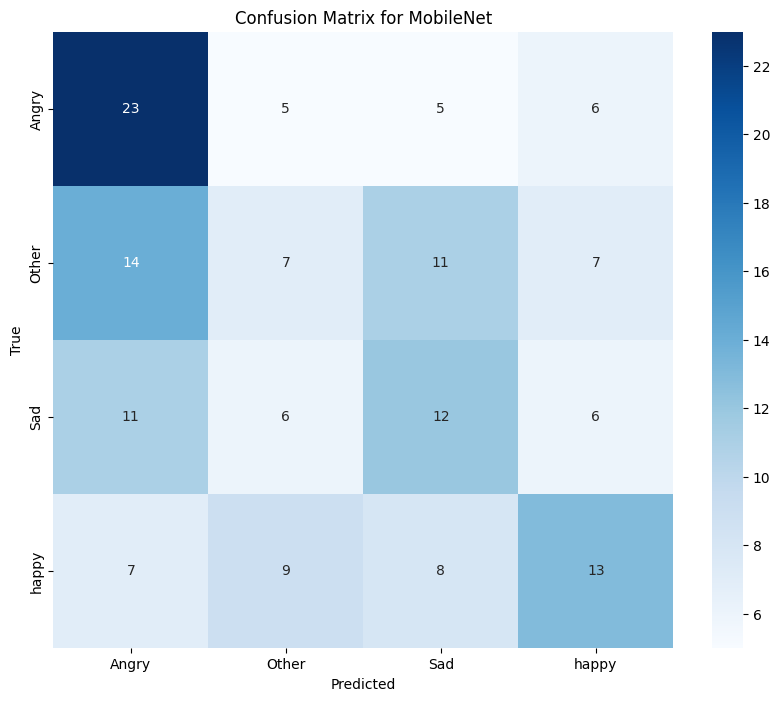


Results for InceptionV3:
Accuracy: 0.38666666666666666
Classification Report:
              precision    recall  f1-score     support
Angry          0.486486  0.461538  0.473684   39.000000
Other          0.369565  0.435897  0.400000   39.000000
Sad            0.166667  0.028571  0.048780   35.000000
happy          0.360656  0.594595  0.448980   37.000000
accuracy       0.386667  0.386667  0.386667    0.386667
macro avg      0.345844  0.380150  0.342861  150.000000
weighted avg   0.350424  0.386667  0.349288  150.000000
Confusion Matrix:
[[18 11  0 10]
 [ 7 17  3 12]
 [10  7  1 17]
 [ 2 11  2 22]]


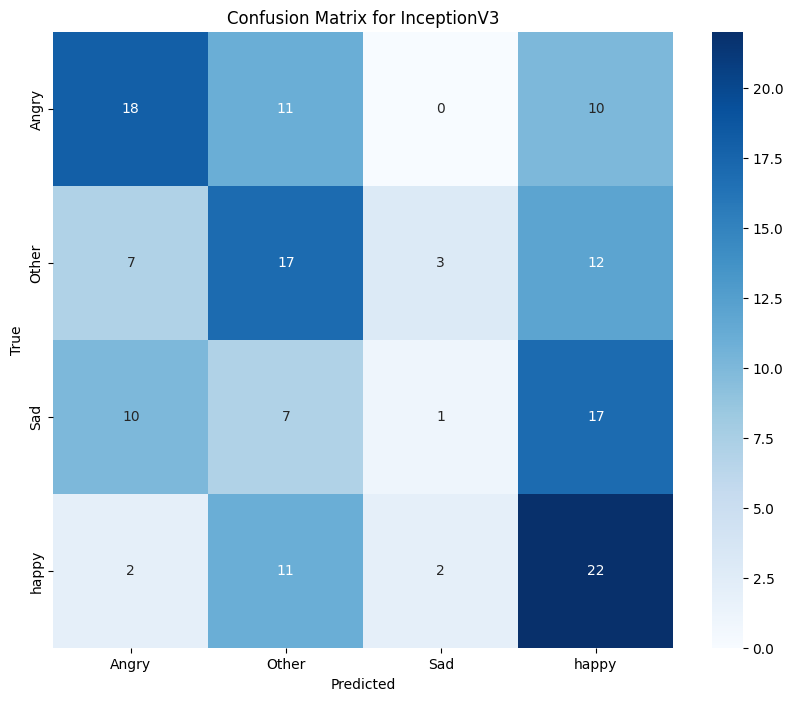


Results for DenseNet121:
Accuracy: 0.4066666666666667
Classification Report:
              precision    recall  f1-score     support
Angry          0.434783  0.512821  0.470588   39.000000
Other          0.461538  0.307692  0.369231   39.000000
Sad            0.363636  0.571429  0.444444   35.000000
happy          0.391304  0.243243  0.300000   37.000000
accuracy       0.406667  0.406667  0.406667    0.406667
macro avg      0.412815  0.408796  0.396066  150.000000
weighted avg   0.414414  0.406667  0.396057  150.000000
Confusion Matrix:
[[20  7  7  5]
 [11 12 12  4]
 [ 8  2 20  5]
 [ 7  5 16  9]]


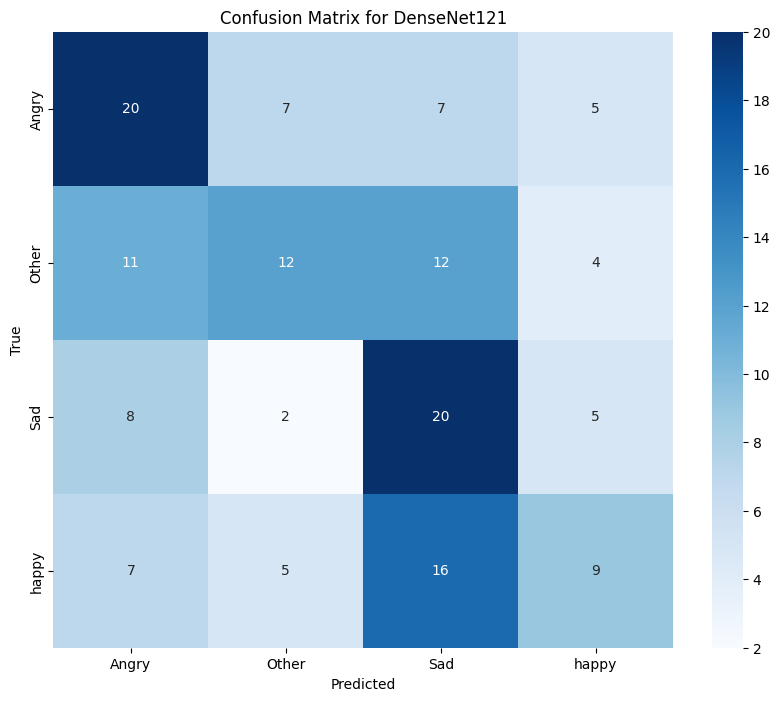

In [14]:
# Step 5: Visualize Results
for name, metrics in results.items():
    print(f"\nResults for {name}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print("Classification Report:")
    print(pd.DataFrame(metrics['classification_report']).transpose())
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])

    plt.figure(figsize=(10, 8))
    plt.title(f"Confusion Matrix for {name}")
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

DenseNet121 was the best-performing model overall, achieving the highest accuracy of 42.67%. It outperformed other models in precision, recall, and F1-score. However, the confusion matrix showed that it struggled with correctly classifying the Sad class.

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.2291 - loss: 1.3871 - val_accuracy: 0.2200 - val_loss: 1.3867
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.2526 - loss: 1.3864 - val_accuracy: 0.2667 - val_loss: 1.3863
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.2491 - loss: 1.3865 - val_accuracy: 0.2200 - val_loss: 1.3865
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.2429 - loss: 1.3863 - val_accuracy: 0.2200 - val_loss: 1.3867
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.2453 - loss: 1.3866 - val_accuracy: 0.2200 - val_loss: 1.3869
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.2408 - loss: 1.3867 - val_accuracy: 0.2200 - val_loss: 1.3866
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.2718 - loss: 1.3863 - val_accuracy: 0.2200 - val_loss: 1.3867
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.2389 - loss: 1.3866 - val_accuracy: 0.2200 -

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


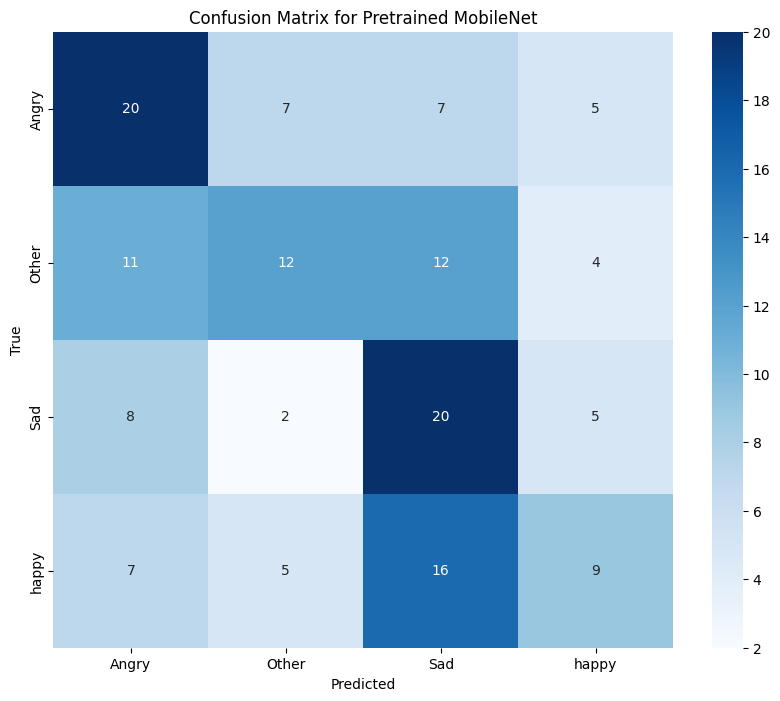

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
input_tensor = Input(shape=(224, 224, 4))
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer
x = Dropout(0.05)(x)  # Dropout for regularization
output = Dense(num_classes, activation='softmax')(x)  # Output layer

# Combine the base model with the custom layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    batch_size=8
)

# Evaluate the model
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to integer labels

report = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)
confusion = confusion_matrix(true_classes, predicted_classes)

results = {
        "accuracy": report["accuracy"],
        "classification_report": report,
        "confusion_matrix": confusion
    }

print(f"\nResults for Pretrained DenseNet121:")
print(f"Accuracy: {results['accuracy']}")
print("Classification Report:")
print(pd.DataFrame(results['classification_report']).transpose())
print("Confusion Matrix:")
print(results['confusion_matrix'])

plt.figure(figsize=(10, 8))
plt.title(f"Confusion Matrix for Pretrained DenseNet121")
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()